In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="KzV30ZzPYHjLtXGdoSTm")
project = rf.workspace("dip-hcetp").project("lff-9co0e")
version = project.version(16)
dataset = version.download("coco-segmentation")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to LFF-16 in coco-segmentation:: 100%|██████████| 2946/2946 [00:00<00:00, 4762.16it/s]


In [ ]:
import json

def fix_category_ids(annotations_file):
    # Define valid category mappings: {Original: New}
    category_mapping = {
        1: 0,  # Farm -> 0
        2: 1,  # Forest -> 1
        3: 2   # Rocky -> 2
    }

    with open(annotations_file, "r") as f:
        data = json.load(f)

    # Fix category_id in annotations
    for annotation in data['annotations']:
        if annotation['category_id'] in category_mapping:
            annotation['category_id'] = category_mapping[annotation['category_id']]
        else:
            print(f"Warning: Found invalid category_id {annotation['category_id']}")

    # Save the updated JSON
    with open(annotations_file, "w") as f:
        json.dump(data, f, indent=4)
    print(f"Fixed {annotations_file}")

# Apply to both train and validation datasets
fix_category_ids("/content/drive/MyDrive/LFF-16/annotations/_annotationstrain.coco.json")
fix_category_ids("/content/drive/MyDrive/LFF-16/annotations/_annotationsval.coco.json")


Fixed /content/drive/MyDrive/LFF-16/annotations/_annotationstrain.coco.json
Fixed /content/drive/MyDrive/LFF-16/annotations/_annotationsval.coco.json


In [ ]:
import json
import numpy as np
import cv2
import os
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils

def generate_masks_from_coco(annotations_file, images_dir, masks_dir, img_size=None):
    # Create masks directory if it doesn't exist
    os.makedirs(masks_dir, exist_ok=True)

    # Initialize COCO API for instance annotations
    coco = COCO(annotations_file)

    # Get all image IDs
    image_ids = coco.getImgIds()

    # Process each image in the dataset
    for img_id in image_ids:
        # Load image info and annotations
        img_info = coco.loadImgs(img_id)[0]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        # Create an empty mask for the entire image
        height, width = img_info['height'], img_info['width']
        mask = np.zeros((height, width), dtype=np.uint8)

        # Loop over annotations and draw the masks
        for ann in anns:
            category_id = ann['category_id']  # Use the category_id as pixel value
            rle = coco.annToRLE(ann)  # Decode RLE mask
            mask_instance = mask_utils.decode(rle)

            # Set mask pixels to the category_id (0, 1, or 2)
            mask[mask_instance == 1] = category_id

        # Resize mask if a new size is provided (e.g., 224x224 for MobileNetV2)
        if img_size is not None:
            mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

        # Save the mask as a PNG file
        mask_filename = os.path.join(masks_dir, f"{img_info['file_name'].replace('.jpg', '.png')}")
        cv2.imwrite(mask_filename, mask)

        print(f"Saved mask: {mask_filename}")

# Example usage:
annotations_file = "/content/drive/MyDrive/LFF-16/annotations/_annotationsval.coco.json"
images_dir = "/content/drive/MyDrive/LFF-16/valid"
masks_dir = "/content/drive/MyDrive/LFF-16/mask_val"

# Generate masks (Optional: Resize masks to 224x224 for MobileNetV2 input)
generate_masks_from_coco(annotations_file, images_dir, masks_dir, img_size=224)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Saved mask: /content/drive/MyDrive/LFF-16/mask_val/forrest-284-_png.rf.06c8235271502335b3efa59f258bc56c.png
Saved mask: /content/drive/MyDrive/LFF-16/mask_val/Screenshot-from-2024-10-10-12-12-05_png.rf.059ebb186773bca8aadaf4159263468c.png
Saved mask: /content/drive/MyDrive/LFF-16/mask_val/Screenshot-from-2024-09-18-13-57-30_png.rf.04e1fbe9edd5c1bb1b1e2a350a0265e3.png
Saved mask: /content/drive/MyDrive/LFF-16/mask_val/Screenshot-from-2024-10-10-01-46-23_png.rf.00e004c2f2ce14e964630ab37e91a24b.png
Saved mask: /content/drive/MyDrive/LFF-16/mask_val/Screenshot-from-2024-09-25-00-13-37_png.rf.05da710e246d387a078f0adb0b48aa0c.png
Saved mask: /content/drive/MyDrive/LFF-16/mask_val/forrest-168-_png.rf.06b64e4ba7ea087e050cc7f5a97e41f1.png
Saved mask: /content/drive/MyDrive/LFF-16/mask_val/Screenshot-from-2024-10-10-01-28-17_png.rf.087c42bee3012012c59242e71d803abe.png
Saved mask: /content/drive/MyDrive/LFF-16/mask

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import glob
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [2]:
IMG_SIZE = 224  # Image size for MobileNetV2
NUM_CLASSES = 3  # Farm, Forest, Rocky land

def load_images_and_masks(image_dir, mask_dir):
    images, masks = [], []
    for img_file in glob.glob(f"{image_dir}/*.jpg"):
        # Load image and mask
        img = img_to_array(load_img(img_file, target_size=(IMG_SIZE, IMG_SIZE))) / 255.0
        mask_path = img_file.replace(image_dir, mask_dir).replace('.jpg', '.png')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

        images.append(img)
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    return images, masks

# Load train and validation data
train_images, train_masks = load_images_and_masks('/content/drive/MyDrive/LFF-16/train/images', '/content/drive/MyDrive/LFF-16/mask_train')
val_images, val_masks = load_images_and_masks('/content/drive/MyDrive/LFF-16/valid/images', '/content/drive/MyDrive/LFF-16/mask_val')


In [3]:
def one_hot_encode_masks(masks, num_classes):
    masks = masks.astype(np.int32)
    one_hot_masks = np.eye(num_classes)[masks]
    return one_hot_masks.reshape(-1, IMG_SIZE, IMG_SIZE, num_classes)

train_masks = one_hot_encode_masks(train_masks, NUM_CLASSES)
val_masks = one_hot_encode_masks(val_masks, NUM_CLASSES)


In [4]:
from tensorflow.keras import regularizers

def create_model():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                   include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze base layers

    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Encoder
    x = base_model(inputs, training=False)

    # Decoder - Upsampling with L2 regularization applied to Conv2DTranspose layers
    x = tf.keras.layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding='same', activation='relu',
                                        kernel_regularizer=regularizers.l2(0.001))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same', activation='relu',
                                        kernel_regularizer=regularizers.l2(0.001))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu',
                                        kernel_regularizer=regularizers.l2(0.001))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu',
                                        kernel_regularizer=regularizers.l2(0.001))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu',
                                        kernel_regularizer=regularizers.l2(0.001))(x)

    # Final output layer with softmax activation (for segmentation)
    outputs = tf.keras.layers.Conv2D(NUM_CLASSES, kernel_size=1, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

create_model().summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 512)         │       5,898,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 112, 112, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 224, 224, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 3)         │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,724,035 (37.09 MB)

 Trainable params: 7,466,051 (28.48 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# Define a Dice coefficient function
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

model=create_model()
# Compile the model with additional metrics
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', dice_coefficient, tf.metrics.Recall(), tf.metrics.Precision(), F1Score()])

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
EPOCHS = 30
BATCH_SIZE = 8

history = model.fit(train_images, train_masks,
          validation_data=(val_images, val_masks),
          epochs=EPOCHS, batch_size=BATCH_SIZE,
          callbacks=[early_stopping, lr_scheduler])


Epoch 1/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - accuracy: 0.5444 - dice_coefficient: 0.4914 - f1_score: 0.4097 - loss: 1.1177 - precision: 0.7208 - recall: 0.3000 - val_accuracy: 0.9544 - val_dice_coefficient: 0.8618 - val_f1_score: 0.9444 - val_loss: 0.3620 - val_precision: 0.9750 - val_recall: 0.9157 - learning_rate: 0.0010
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9102 - dice_coefficient: 0.8404 - f1_score: 0.9056 - loss: 0.4379 - precision: 0.9331 - recall: 0.8797 - val_accuracy: 0.9553 - val_dice_coefficient: 0.9125 - val_f1_score: 0.9545 - val_loss: 0.2645 - val_precision: 0.9617 - val_recall: 0.9474 - learning_rate: 0.0010
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9200 - dice_coefficient: 0.8660 - f1_score: 0.9191 - loss: 0.3696 - precision: 0.9350 - recall: 0.9037 - val_accuracy: 0.9556 - val_dice_coefficient: 0.8902 - val_f1_score: 0.9548 - val_loss: 0.2746 - val_precision: 0.9675 - val_recall: 0.9424 - learning_rate

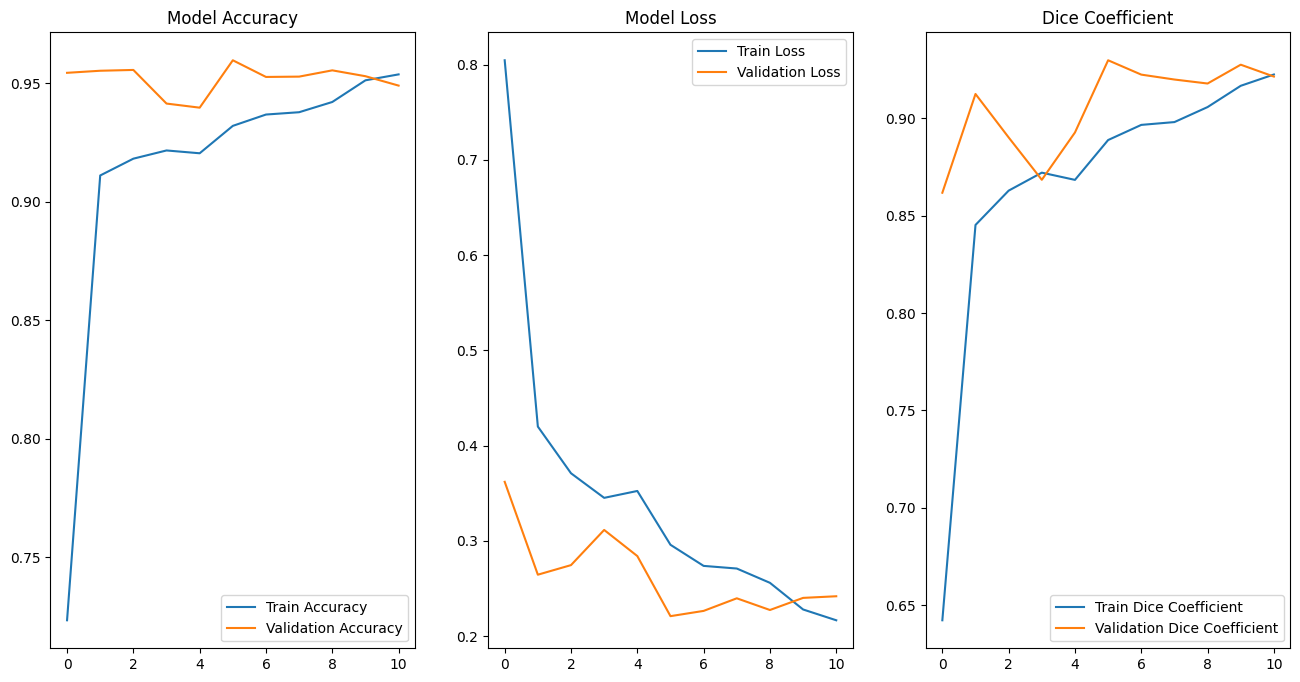

In [7]:
import matplotlib.pyplot as plt

# Plotting function
def plot_training_history(history):
    # Get metrics from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    dice = history.history['dice_coefficient']
    val_dice = history.history['val_dice_coefficient']

    epochs_range = range(len(acc))

    # Plot accuracy
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Model Accuracy')

    # Plot loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Model Loss')

    # Plot Dice Coefficient
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, dice, label='Train Dice Coefficient')
    plt.plot(epochs_range, val_dice, label='Validation Dice Coefficient')
    plt.legend(loc='lower right')
    plt.title('Dice Coefficient')

    plt.show()

# Call the function to plot training history
plot_training_history(history)


12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 929ms/step


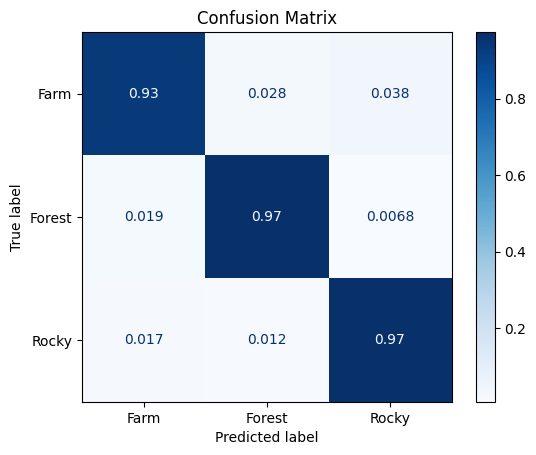

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

def plot_confusion_matrix(model, val_images, val_masks, normalize=False):
    # Get predictions for the validation set
    val_predictions = model.predict(val_images)
    val_predictions_classes = np.argmax(val_predictions, axis=-1)  # Shape: (num_samples, IMG_SIZE, IMG_SIZE)
    val_masks_classes = np.argmax(val_masks, axis=-1)  # Shape: (num_samples, IMG_SIZE, IMG_SIZE)

    # Flatten the arrays to compare pixel-wise
    val_predictions_classes_flat = val_predictions_classes.flatten()
    val_masks_classes_flat = val_masks_classes.flatten()

    # Calculate the confusion matrix
    cm = confusion_matrix(val_masks_classes_flat, val_predictions_classes_flat, labels=[0, 1, 2])

    # Normalize the confusion matrix if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (true label)

    # Create a confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Farm', 'Forest', 'Rocky'])
    disp.plot(cmap='Blues')

    # Add title based on normalization
    plt.title('Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.show()




# Call the function to plot the confusion matrix and print evaluation metrics
plot_confusion_matrix(model, val_images, val_masks, normalize=True)


In [10]:
# Save the trained model
model.save('/content/drive/MyDrive/LFF-16/mobilenetv2_segmentation2.h5')

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/drive/MyDrive/LFF-16/mobilenetv2_segmentation2.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpn31tv1fd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_320')
Output Type:
  TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)
Captures:
  136072887346352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068325346464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068325352448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068325349808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068325350688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068325356144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068325355616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068325356672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068325356848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068325357728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

In [ ]:
from google.colab.patches import cv2_imshow  # For displaying in Colab
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf  # Import TensorFlow

# Load the TFLite model and create an interpreter
model_path = '/content/drive/MyDrive/LFF-16/mobilenetv2_segmentation2.tflite'  # Change this to your actual model path
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define class colors (R, G, B)
COLORS = {
    0: (0, 255, 0),   # Farm: Green
    1: (255, 0, 0),   # Forest: Blue
    2: (42, 42, 165)  # Rocky Land: Brown
}

def colorize_mask(mask):
    """Convert a mask with class IDs to a colored mask."""
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_id, color in COLORS.items():
        color_mask[mask == class_id] = color
    return color_mask

def overlay_mask_on_image(image, mask, alpha=0.5):
    """Overlay the colored mask on the original image."""
    overlay = cv2.addWeighted(image, 1 - alpha, mask, alpha, 0)
    return overlay

def run_inference_on_images(image_dir):
    """Run inference on all images in the directory and display results."""
    for img_file in os.listdir(image_dir):
        if img_file.endswith('.jpg') or img_file.endswith('.png'):
            # Load the original image
            img_path = os.path.join(image_dir, img_file)
            original_img = cv2.imread(img_path)
            original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

            # Preprocess the image for model input
            img = img_to_array(load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))) / 255.0
            img = np.expand_dims(img, axis=0).astype(np.float32)

            # Run inference
            interpreter.set_tensor(input_details[0]['index'], img)
            interpreter.invoke()

            # Get predicted mask and resize to original size
            output = interpreter.get_tensor(output_details[0]['index'])[0]
            predicted_mask = np.argmax(output, axis=-1).astype(np.uint8)

            predicted_mask_resized = cv2.resize(
                predicted_mask, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_NEAREST
            )

            # Convert predicted mask to colored mask
            color_mask = colorize_mask(predicted_mask_resized)

            # Overlay the mask on the original image
            overlay_image = overlay_mask_on_image(original_img_rgb, color_mask)

            # Display the original image, mask, and overlay
            print(f"Displaying: {img_file}")
            cv2_imshow(original_img_rgb)   # Original image
            cv2_imshow(color_mask)         # Predicted mask
            cv2_imshow(overlay_image)      # Overlay of image and mask

# Run inference on all test images
run_inference_on_images('/content/drive/MyDrive/LFF-16/test')
